In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.simplefilter('ignore')
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate, GridSearchCV

In [18]:
class hybrid(object):
    
    def __init__ (self,user_id,ratings):
        
        self.user_id = user_id
        self.md = pd.read_csv('dataset/processed/FinalData.csv')
        self.ratings = ratings
        self.res=None
        print(ratings)
        print(ratings[(ratings['user_id'] == user_id)][['user_id','book_id', 'rating']])
        print('STARTING COLABORATIVE')
        self.collaborative_rating = self.collaborative(self.ratings, self.user_id)
        print('STARTING CONTENT')
        self.content_rating = self.content_based(self.md,self.ratings,self.user_id)
        print('STARTING POPULARITY')
        self.popularity_rating = self.popularity(self.md)
        print('STARTING HYBRID')
        self.final_hybrid(self.md, self.popularity_rating , self.collaborative_rating, self.content_rating, self.user_id)
        
        
    #Popularity#

    def popularity(self,md):


        fd = pd.read_csv('dataset/processed/AverageRatings.csv')
        fd1 = pd.read_csv('dataset/processed/RatingsCount.csv')
	
        fd[fd['rating'].notnull()]['rating'] = fd[fd['rating'].notnull()]['rating'].astype('float')
        vote_averages= fd[fd['rating'].notnull()]['rating'] 
        C = vote_averages.mean()


        fd1[fd1['rating'].notnull()]['rating'] = fd1[fd1['rating'].notnull()]['rating'].astype('float')
        vote_counts = fd1[fd1['rating'].notnull()]['rating']
        m = len(vote_counts)

        md['ratings_count'] = fd1['rating']
        md['average_rating'] = fd['rating']

        qualified = md[(md['ratings_count'].notnull())][['book_id','title', 'authors', 'ratings_count', 'average_rating']]

        qualified['ratings_count'] = qualified['ratings_count'].astype('float')

        qualified['average_rating'] = qualified['average_rating'].astype('float')

        qualified.shape

        def weighted_rating(x):
            v = x['ratings_count']
            R = x['average_rating']
            return (v/(v+m) * R) + (m/(m+v) * C)

        qualified['popularity_rating'] = qualified.apply(weighted_rating, axis=1)
        pop = qualified[['book_id','popularity_rating']]
        print(qualified.shape)
        print(pop.shape)

        return pop
    ### Collaborative ##

#     def collaborative(self,ratings,user_id):

#         reader = Reader(rating_scale=(0, 10))
#         #ratings.head()

#         temp_ratings = ratings



#         data = Dataset.load_from_df(temp_ratings[['user_id', 'book_id', 'rating']], reader)
# #         data.split(n_folds=2)

#         ## Training the data ##
#         svd = SVD()
#         cross_validate(svd, data, measures=['RMSE', 'MAE'])

#         trainset = data.build_full_trainset()

#         algo = SVD()
#         algo.fit(trainset)

#         #svd.train(trainset)
#         ## Testing the data ##

#         from collections import defaultdict
#         testset = trainset.build_anti_testset()
#         predictions = algo.test(testset)

#         count = 0
     
#         for uid, iid, true_r, est, _ in predictions:

#              if uid == user_id:
#                 count = count+1
#                 temp_ratings.loc[len(temp_ratings)+1]= [uid,iid,est]

#         #print("count\n")
#         #print(count)
#         #print("\n--------here-------\n")	
#         #print(temp_ratings)

#         cb = temp_ratings[(temp_ratings['user_id'] == user_id)][['book_id', 'rating']]
#         #print("\n--------here-------\n")
#         #print(cb)
        
#         cb = temp_ratings[(temp_ratings['user_id'] == user_id)][['book_id', 'rating']]

#         return(cb)

    def collaborative(self,ratings,user_id):
        reader = Reader(rating_scale=(0, 10))
        temp_ratings = ratings

        data = Dataset.load_from_df(temp_ratings[['user_id', 'book_id', 'rating']], reader)
        trainset = data.build_full_trainset()
        
        param_grid = {'n_epochs': [10, 20], 'lr_all': [0.005, 0.01], 'reg_all': [0.2, 0.4, 0.6]}
        gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=2)

        gs.fit(data)
        
        algo = gs.best_estimator['rmse']
        algo.fit(trainset)

        unknown_ratings = trainset.build_anti_testset()
        predictions = algo.test(unknown_ratings)
        
        result = [ [p.uid, p.iid, p.est] for p in predictions if p.uid == user_id]
        result = np.array(result)
        result_dict = {'book_id': result[:,1], 'rating': result[:,2]}
        result_df = pd.DataFrame.from_dict(result_dict)
        result_df['rating'] = result_df['rating'].astype(float)

        return (result_df)


    ##### CONTENT ######

    def content_based(self,md,ratings,user_id):       

        md['book_id'] = md['book_id'].astype('str')
        md['year'] = md['year'].astype('str')
        ratings['book_id'] = ratings['book_id'].astype('str')
        ratings['user_id'] = ratings['user_id'].astype('int')
        ratings['rating'] = ratings['rating'].astype('int')
        md['authors'] = md['authors'].str.replace(' ','')
        md['authors'] = md['authors'].str.lower()
        md['authors'] = md['authors'].str.replace(',',' ')
        md['authors'] = md['authors'].apply(lambda x: [x])
        md['publisher'] = md['publisher'].str.replace(' ','')
        md['publisher'] = md['publisher'].str.lower()
        md['publisher'] = md['publisher'].apply(lambda x: [x])
        md['year'] = md['year'].apply(lambda x: [x])
        md['soup'] = md['authors'] + md['year'] + md['publisher']

        md['soup'] = md['soup'].str.join(' ')
        #print('MD_SOUP',md['soup'])
        count = CountVectorizer(analyzer='word',ngram_range=(1,1),min_df=0, stop_words='english') 
        #how it works? add more attrs
        count_matrix = count.fit_transform(md['soup'].values.astype('U'))
        #print('CM',count_matrix.shape)
        cosine_sim = cosine_similarity(count_matrix, count_matrix)
        #print('CS',cosine_sim.shape)

        def build_user_profiles():
            user_profiles=np.full((278858 ,1000),np.nan)
            for i in range(0,45000):
                u=ratings.iloc[i]['user_id']
                b=ratings.iloc[i]['book_id']
                b2=self.md.index[self.md['book_id'] == b].tolist()[0]
                #b2 is id of book in book attrs table md
                user_profiles[u][b2-1]=ratings.iloc[i]['rating']
                
            return user_profiles

        user_profiles=build_user_profiles()
        print('profiles done')

        def _get_similar_items_to_user_profile(person_id):
            #Computes the cosine similarity between the user profile and all item profiles

            user_ratings = np.empty((1000,1))
            for i in range(0,999):
                book_sim=cosine_sim[i] #how book is similar to all others
                user_sim=user_profiles[person_id] #user all book ratings
                user_sim_bool = [x is not np.nan for x in user_sim]
                user_sim=np.nan_to_num(user_sim)
                non_zero_sim_sum = book_sim.dot(user_sim_bool)
                user_ratings[i]=(book_sim.dot(user_sim))/non_zero_sim_sum
                #print('URi', user_ratings[i], book_sim, user_sim, non_zero_sim_sum)
                #similarities*ratings/similarities sum = avg rating

            return user_ratings

        content_ratings = _get_similar_items_to_user_profile(user_id)
        num = md[['book_id']]
        num1 = pd.DataFrame(data=content_ratings[0:,0:])
        frames = [num, num1]

        content_rating = pd.concat(frames, axis =1,join_axes=[num.index])
        content_rating.columns=['book_id', 'content_rating']
        #print('CR', content_ratings)

        return(content_rating)

    
    def final_hybrid(self,md, popularity_rating , collaborative_rating, content_rating, user_id):

        hyb = md[['book_id']]
        title = md[['book_id','title', 'year']]

        hyb = hyb.merge(title,on = 'book_id')
        hyb = hyb.merge(self.collaborative_rating,on = 'book_id')
        hyb = hyb.merge(self.popularity_rating, on='book_id')
        hyb = hyb.merge(self.content_rating, on='book_id')

        def weighted_rating(x):
#             v = x['rating'].map(lambda x: float(x))
            v = x['rating']
            R = x['popularity_rating']
            c = x['content_rating']
            return 0.4*v + 0.2*R + 0.4 * c


        hyb['hyb_rating'] = hyb.apply(weighted_rating, axis=1)
        hyb = hyb.sort_values('hyb_rating', ascending=False).head(999)
        hyb.columns = ['Book ID' , 'Title', 'year', 'Collaborative Rating', 'Popularity Rating' , 'Content Rating', 'Hybrid Rating']
        self.res=hyb
        print(len(hyb['Hybrid Rating']))
        print(hyb)

In [19]:
ratings = pd.read_csv('dataset/processed/FinalRatings.csv')[0:45000]
userId=11676
print('\n----------------Results for'+str(userId)+'-------------------')
h = hybrid(userId,ratings)


----------------Results for11676-------------------
       user_id     book_id  rating
0       276746  0449006522       0
1       276746  055356451X       0
2       276755  0451166892       5
3       276796  0330332775       5
4       276847  0446364193       0
...        ...         ...     ...
44995   247055  0446612545       0
44996   247055  051513290X       0
44997   247055  0553278746       0
44998   247055  0553576925       0
44999   247055  0671004573       0

[45000 rows x 3 columns]
      user_id     book_id  rating
2928    11676  0002005018       8
2929    11676  0060173289       0
2930    11676  0060188731       6
2931    11676  0060915544       0
2932    11676  0060917016       0
...       ...         ...     ...
3233    11676  3257233051      10
3234    11676  3453212150      10
3235    11676  349913358X       0
3236    11676  8433914545       8
3237    11676  9724119378       0

[310 rows x 3 columns]
STARTING COLABORATIVE
STARTING CONTENT
profiles done
STARTING POPULAR

In [27]:
h.res=h.res.rename(columns={"Book ID": "book_id", "Title": "title","Hybrid Rating":"hybrid_rating","Collaborative Rating":"colab_rating", "Content Rating":"content_rating", "Popularity Rating":"pop_rating"})

### USER CHARACTER

In [28]:
finalRatings = pd.read_csv('dataset/processed/FinalRatings.csv')[0:45000]
userRatings=finalRatings[finalRatings.user_id==11676]
finalData=pd.read_csv('dataset/processed/FinalData.csv')

In [29]:
merged = pd.merge(userRatings, finalData, on=['book_id','book_id'])

In [30]:
merged.sort_values(by=['rating'],ascending=False).head(20)

,user_id,book_id,rating,title,authors,year,publisher
208,11676,0553289063,10,An Inconvenient Woman,Dominick Dunne,1991,Bantam Books
24,11676,014023828X,10,The Tortilla Curtain,T. Coraghessan Boyle,1996,Penguin Books
35,11676,0312195516,10,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA
231,11676,0671027387,10,Deception Point,Dan Brown,2002,Pocket
227,11676,0671004573,10,Before I Say Good-Bye,Mary Higgins Clark,2001,Pocket
39,11676,0312963009,10,Neanderthal: A Novel,John Darnton,1997,St. Martin's Press
220,11676,0609605925,10,Angel Falls,KRISTIN HANNAH,2000,Crown
219,11676,0590450875,10,I Spy: A Book of Picture Riddles,Jean Marzollo,1992,Scholastic
216,11676,0553802488,10,The Face,DEAN KOONTZ,2003,Bantam
212,11676,0553578693,10,The Next Accident,LISA GARDNER,2002,Bantam


## RESULTS

### Hybrid

In [74]:
hyb_res=h.res.sort_values(by=['hybrid_rating'],ascending=False)
hyb_res.head(10)

,book_id,title,year,colab_rating,pop_rating,content_rating,hybrid_rating
200,0520011171,Sappho: A New Translation,[1958],3.974209,2.943586,8.000000,5.378401
550,1860198597,How to Draw Celtic Knotwork: A Practical Handbook,[0],3.603852,2.943586,8.000000,5.230258
28,067176537X,The Therapeutic Touch: How to Use Your Hands t...,[1979],4.691200,2.943586,6.137034,4.920011
632,3404118960,Die SÃ?Â¤ulen der Erde. Roman.,[1992],6.385157,2.943578,2.166138,4.009234
533,0394551427,Shoah,[1985],5.513874,2.943616,2.629684,3.846146
239,0590481371,I Spy Spooky Night: A Book of Picture Riddles ...,[1996],5.814681,2.943586,2.315478,3.840781
406,0553202294,Sun Signs,[1981],5.305694,2.943685,2.706963,3.793800
480,0316735027,The True and Outstanding Adventures of the Hun...,[2004],5.503344,2.943586,2.465936,3.776429
581,0679801146,Alanna: The First Adventure (Song of the Lione...,[1989],5.659925,2.943610,2.291338,3.769227
222,0684193957,ALL THAT REMAINS,[1992],5.342721,2.943616,2.574956,3.755794


### Content based

In [73]:
cont_res=h.res.sort_values(by=['content_rating'],ascending=False)
cont_res.head(10)

,book_id,title,year,colab_rating,pop_rating,content_rating,hybrid_rating
200,0520011171,Sappho: A New Translation,[1958],3.974209,2.943586,8.000000,5.378401
550,1860198597,How to Draw Celtic Knotwork: A Practical Handbook,[0],3.603852,2.943586,8.000000,5.230258
28,067176537X,The Therapeutic Touch: How to Use Your Hands t...,[1979],4.691200,2.943586,6.137034,4.920011
348,0192815318,Cranford (The World's Classics),[1982],3.839718,2.943613,3.889233,3.680303
241,0684180200,NEW SHOE,[1983],3.359166,2.943595,3.861852,3.477126
531,0671525794,The Kingdom by the Sea: A Journey Around Great...,[1984],4.115701,2.943610,3.140237,3.491097
237,0449202631,Danger,[1985],3.775403,2.943586,2.918526,3.266289
363,0486206173,Rubinstein's Chess Masterpieces,[1941],4.929608,2.943586,2.818182,3.687833
49,0451625889,The Prince,[1952],3.920103,2.943601,2.796838,3.275497
240,0684177730,The SKULL BENEATH THE SKIN,[1982],3.404500,2.943586,2.789474,3.066307


### Colaborative 

In [72]:
col_res=h.res.sort_values(by=['colab_rating'],ascending=False)
col_res.head(10)

,book_id,title,year,colab_rating,pop_rating,content_rating,hybrid_rating
491,2253007102,Les Fleurs Du Mal,[1972],6.673473,2.943586,0.000000,3.258107
62,8445071408,El Senor De Los Anillos: LA Comunidad Del Anil...,[2001],6.538128,2.943616,0.940848,3.580314
632,3404118960,Die SÃ?Â¤ulen der Erde. Roman.,[1992],6.385157,2.943578,2.166138,4.009234
477,0743213831,America the Beautiful: A Novel,[2001],6.156677,2.943613,0.974115,3.441039
612,0689832877,Sunwing (Aladdin Fantasy),[2001],6.130525,2.943613,0.978712,3.432417
253,0156528207,The Little Prince,[1968],6.102233,2.943586,1.033724,3.443100
650,0312853238,Ender's Game (Ender Wiggins Saga (Paperback)),[1992],5.945700,2.943607,1.875426,3.717172
239,0590481371,I Spy Spooky Night: A Book of Picture Riddles ...,[1996],5.814681,2.943586,2.315478,3.840781
489,2266084372,Pourquoi j'ai mangÃ?Â© mon pÃ?Â¨re,[2000],5.803615,2.943610,1.637127,3.565019
64,8445071777,El Senor De Los Anillos: El Retorno Del Rey (T...,[2001],5.797783,2.943601,1.020304,3.315955


### Popularity

In [70]:
pop_res=h.res.sort_values(by=['pop_rating'],ascending=False)
pop_res.head(10)

,book_id,title,year,colab_rating,pop_rating,content_rating,hybrid_rating
406,0553202294,Sun Signs,[1981],5.305694,2.943685,2.706963,3.793800
513,0684867818,The Looking Glass : A Novel (The Locket Series),[1999],3.914209,2.943678,1.800579,2.874651
481,015600710X,Strange Fits of Passion: A Novel,[1999],4.494529,2.943671,2.044680,3.204418
343,0871138646,Old Flames,[2003],4.040765,2.943668,1.517889,2.812195
35,0380715899,A Soldier of the Great War,[1992],4.192522,2.943660,1.886068,3.020168
415,0821772953,The Morning After,[2004],4.824952,2.943653,2.131237,3.371206
371,080521061X,Montessori Today: A Comprehensive Approach to ...,[1996],5.129349,2.943645,2.337208,3.575352
424,0590687301,Ralph S. Mouse,[2000],3.292549,2.943642,1.319602,2.433589
430,0812519655,Sacred Ground,[1995],3.582220,2.943640,1.492178,2.618487
555,1841952931,Glasgow Zen,[2002],4.678611,2.943639,1.015999,2.866572


### KNN results

In [48]:
knn_res=pd.read_csv('../partial_results/knn_results_for_11676.csv')
knn_res.sort_values(by=['rating'],ascending=False).head(10)

,user_id,book_id,title,rating
77,11676,0439136350,Harry Potter and the Prisoner of Azkaban (Book 3),8.859316
88,11676,0877017883,Griffin &amp; Sabine: An Extraordinary Corresp...,8.637286
281,11676,0590353403,Harry Potter and the Sorcerer's Stone (Book 1),7.869456
3,11676,0553296981,Anne Frank: The Diary of a Young Girl,6.856961
21,11676,0446365386,Gone with the Wind,6.748900
128,11676,1857022424,Shipping News,6.734628
230,11676,0671617028,The Color Purple,6.652905
383,11676,0375400117,Memoirs of a Geisha,6.598039
305,11676,0842329129,Left Behind: A Novel of the Earth's Last Days ...,6.381755
14,11676,0553213148,Anne of Avonlea (Anne of Green Gables Novels (...,6.253159


### Jaccard measure

In [91]:
from sklearn.metrics import jaccard_similarity_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [69]:
y_pred = knn_res['book_id'].tolist()
y_true = knn_res['book_id'].tolist()
jaccard_similarity_score(y_true, y_pred)

1.0

In [85]:
LABELS=['HYBRID','CONTENT','COLLABORATIVE','POPULARITY','KNN']

In [75]:
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

In [80]:
def create_matrix(n):
    matrix=np.zeros(shape=(5,5))
    results=[hyb_res,cont_res,col_res,pop_res,knn_res]
    for i in range(5):
        elem=results[i]['book_id'].tolist()[0:n]
        for j in range(5):
            sub_elem=results[j]['book_id'].tolist()[0:n]
            matrix[i][j]=jaccard_similarity(elem,sub_elem)
    return matrix

In [102]:
matrix100=create_matrix(100)
matrix20=create_matrix(20)
matrix50=create_matrix(50)

In [103]:
def plot_heatmap(matrix):
    f, ax = plt.subplots(figsize=(10, 7))
    sns.heatmap(matrix, xticklabels=LABELS, yticklabels=LABELS,annot=True,cmap="Blues")
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!

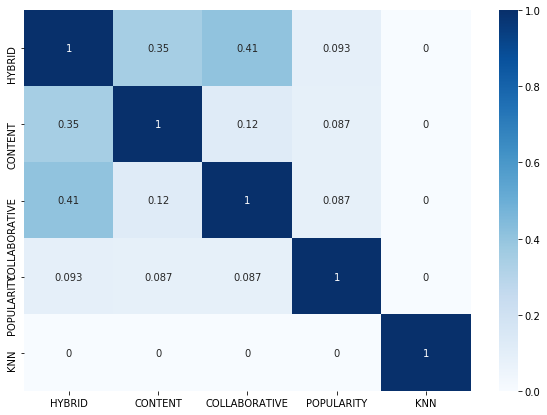

In [105]:
plot_heatmap(matrix100)

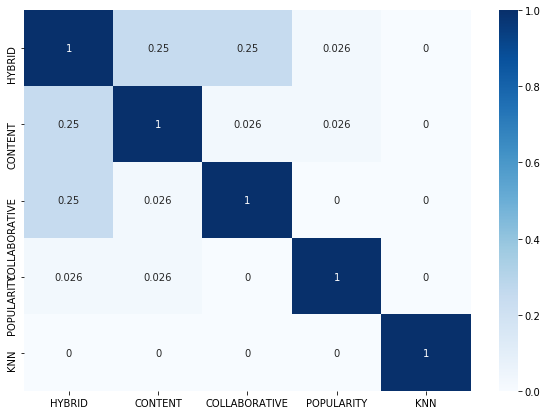

In [107]:
plot_heatmap(matrix20)